# Multilayer Perceptron (MLP) Binary Classification Example
Here is demonstrated how to use the **MLPBinaryClassifier** module from the `rice_ml` library to classify data.

In this example, a synthetically generated, non-linearly separable dataset (concentric circles) will be used to train, test, and evaluate the model.

**Goal: Successfully classify data that cannot be separated by a single straight line, demonstrating the power of hidden layers and non-linear activation functions.**

In [1]:
import numpy as np
from sklearn.datasets import make_circles 
from rice_ml.supervised_learning.multilayer_perceptron import MLPBinaryClassifier
from rice_ml.processing.preprocessing import train_test_split, standardize
from rice_ml.processing.post_processing import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings 
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)


## 1. Load Data and Preparation
Generate a concentric circles dataset, specifically chosen to force the MLP to utilize its hidden layers to learn complex boundaries.

In [2]:
# Generate synthetic non-linear data
X_raw, y = make_circles(
    n_samples = 200, 
    factor = 0.5, # Controls separation distance
    noise = 0.1,  # Add some noise
    random_state = 67
)

# Ensure y is strictly {0, 1}
y = y.astype(int) 

print(f"Total Samples: {X_raw.shape[0]}")
print(f"Target Classes: {np.unique(y)}")

Total Samples: 200
Target Classes: [0 1]


## 2. Data Pre-Processing: Scaling and Splitting
Standardization is mandatory for the MLP to ensure stable and timely convergence of the backpropagation algorithm.

In [3]:
# 1. Split data into training and test sets *before* scaling
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size = 0.3, random_state = 67
)

# 2. Fit the scaler on the training set and capture the parameters (Fit and Transform mode)
X_train_scaled, params = standardize(X_train_raw, return_params=True)

# 3. Apply the fit to the test set using the captured parameters (Transform only mode)
X_test_scaled = standardize(
    X_test_raw, 
    mean=params['mean'], 
    scale=params['scale']
)

# Verification
print(f"\nTraining Set Size: {X_train_scaled.shape[0]} samples")
print(f"Test Set Size: {X_test_scaled.shape[0]} samples")
print("Standardization applied using only training data statistics (no data leakage).")


Training Set Size: 140 samples
Test Set Size: 60 samples
Standardization applied using only training data statistics (no data leakage).


## 3. Initialize and Train the Model
Define a network architecture with two hidden layers and train it over many epochs, expecting the loss to decrease gradually.

In [4]:
# Initialize MLP with two hidden layers
mlp = MLPBinaryClassifier(
    hidden_layer_sizes=(10, 5), # Layer 1: 10 neurons, Layer 2: 5 neurons
    eta = 0.01, 
    epochs = 1000, # Requires many epochs for convergence on non-linear data
    random_state = 67
)

print("\nBeginning MLP Training (Backpropagation over 1000 epochs)...")

# Fit the model to the training data
mlp.fit(X_train_scaled, y_train)

print("Training Complete.")


Beginning MLP Training (Backpropagation over 1000 epochs)...
Epoch 100/1000, Cost: 98.2546
Epoch 200/1000, Cost: 98.1864
Epoch 300/1000, Cost: 98.3637
Epoch 400/1000, Cost: 98.7041
Epoch 500/1000, Cost: 99.1993
Epoch 600/1000, Cost: 99.9365
Epoch 700/1000, Cost: 101.4373
Epoch 800/1000, Cost: 102.6179
Epoch 900/1000, Cost: 104.1816
Epoch 1000/1000, Cost: 105.5297
Training Complete.


## 4. Prediction and Evaluation
Evaluate the MLP's ability to classify the test data using the complex boundary it has learned. 

In [5]:
# 1. Generate predictions on the held-out test set
y_pred = mlp.predict(X_test_scaled)

# 2. Calculate the Accuracy Score
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- Evaluation Results ---")
print(f"MLP Final Accuracy: {accuracy:.4f}")


--- Evaluation Results ---
MLP Final Accuracy: 0.7167


## 5. Analyzing Convergence and Boundary (Optional)
Plot the cost history to confirm that the training loss steadily decreased over the 1000 epochs.

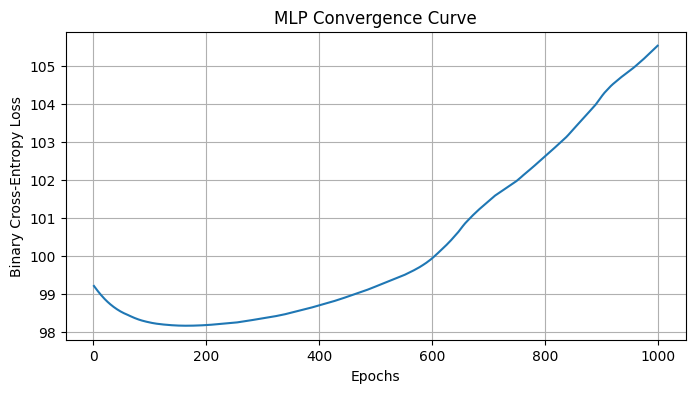

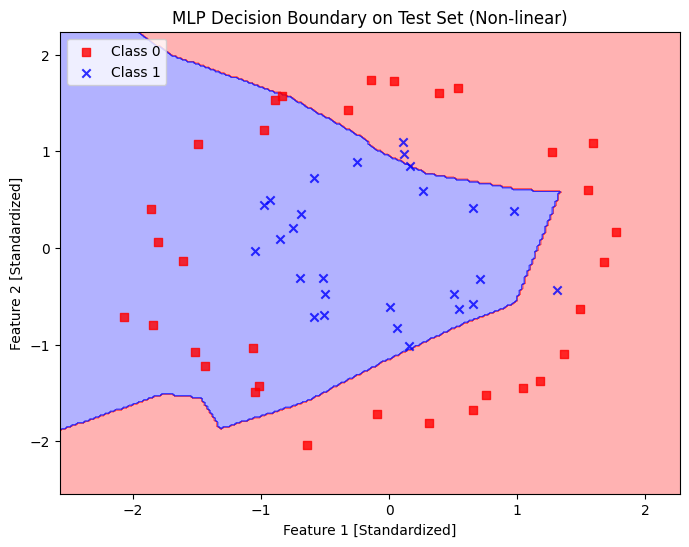

In [7]:
# 6.1 Plot Cost History
plt.figure(figsize=(8, 4))
plt.plot(range(1, mlp.epochs + 1), mlp.cost_history_)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('MLP Convergence Curve')
plt.grid(True)
plt.show()

# 6.2 Plot Decision Boundary (Since we used 2 features)
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f'Class {cl}')

plt.figure(figsize=(8, 6))
plot_decision_regions(X_test_scaled, y_test, classifier=mlp)
plt.xlabel('Feature 1 [Standardized]')
plt.ylabel('Feature 2 [Standardized]')
plt.title('MLP Decision Boundary on Test Set (Non-linear)')
plt.legend(loc='upper left')
plt.show()